### Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from statistics import geometric_mean

orig_cutoffA = 1.0846347878236864
orig_cutoffR = 0.6987727639587653

### Perturbation screen magnetic separation

In [3]:
df = pd.read_csv('../Flow Single-Cell Data - CSV/HHVpert_Screens_magsep_single-cell.csv')
df = df[(df['P1']==True) & (df['P2']==True)]
df = df.rename(columns={'Citrine':'Citrine_Act'})
df['Citrine_Rep'] = np.where(df['mCitrine-A']>1e7, True, False)
df = df[df['Fraction']!='wash']
df['Fraction'] = pd.Categorical(df['Fraction'], categories=['pre-magsep', 'unbound', 'bound'])
aggdf = df.groupby(by=['Reporter', 'Fraction'], as_index=False).mean().sort_values(by=['Reporter', 'Fraction'])

aggdf

,Reporter,Fraction,FSC 488/10-A,FSC 488/10-H,SSC 488/10-A,mCherry-A,mCitrine-A,P1,P2,mCherry,Citrine_Act,Citrine_Rep
0,DY032,pre-magsep,9.830699e+08,7.992112e+08,5.788796e+08,8.513310e+07,1.061871e+07,1.0,1.0,0.906772,0.154790,0.111918
1,DY032,unbound,1.082170e+09,9.018115e+08,3.739109e+08,7.942560e+07,6.665546e+06,1.0,1.0,0.940997,0.251898,0.129479
2,DY032,bound,9.267689e+08,7.207701e+08,1.288594e+09,8.702304e+07,7.490567e+07,1.0,1.0,0.988887,0.963484,0.851640
3,JT039,pre-magsep,9.812887e+08,7.948631e+08,3.897466e+08,1.055722e+08,8.049223e+07,1.0,1.0,0.901604,0.838813,0.673063
4,JT039,unbound,1.062956e+09,9.014005e+08,4.534527e+08,1.387047e+08,8.784665e+06,1.0,1.0,0.965001,0.513272,0.195730
5,JT039,bound,9.455708e+08,7.436425e+08,1.477659e+09,1.169342e+08,1.128946e+08,1.0,1.0,0.980210,0.995306,0.956265


In [4]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

tempdf = df.copy()
tempdf['mCitrine'] = np.log10(tempdf['mCitrine-A'])

def plot_magsep(data_df, agg_df, screentype):
    if screentype == 'Activation':
        reporter = 'DY032'
        citrine = 'Citrine_Act'
        color = '#F3CE48'
        cutoff = 3e6
        upperylim = 4
    elif screentype == 'Repression':
        reporter = 'JT039'
        citrine = 'Citrine_Rep'
        color = '#23BEDB'
        cutoff = 1e7
        upperylim = 2.5
    
    ON = list(agg_df[agg_df['Reporter']==reporter][citrine])
    ON = [round(on*100, 1) for on in ON]
    OFF = [str(round(100-on, 1)) + '%' for on in ON]
    ON = [str(on) + '%' for on in ON]
    
    pal = sns.color_palette([color, color])
    g = sns.FacetGrid(data=data_df[data_df['Reporter']==reporter],
                      col='Fraction', hue='Replicate', palette=pal,
                      aspect=0.92, height=1.35)
    g.map(sns.kdeplot, 'mCitrine', fill=True, bw_adjust=1)
    g.set_titles(template='{col_name}')
    
    plt.xlim([4.5,9.5])
    plt.ylim([0,upperylim])
    plt.xticks([5, 6, 7, 8, 9], ['10$^5$', '10$^6$', '10$^7$', '10$^8$', '10$^9$'])
    for i, ax, on, off in zip(range(6), g.axes.flat, ON, OFF):
        ax.text(0.05, 0.95, off, transform=ax.transAxes, ha='left', va='top')
        ax.text(0.95, 0.95, on, transform=ax.transAxes, ha='right', va='top')
        ax.axvline(x=np.log10(cutoff), ls=':', color='#333333', lw=1)
#         ax.grid(False)
    
    plt.savefig('../Individual Figure Panels/Figure S5/HHVpert_Screens_%s_magsep_kdeplot.png' % screentype, dpi=1200)
    plt.close()
    
plot_magsep(tempdf, aggdf, 'Activation')
plot_magsep(tempdf, aggdf, 'Repression')

print('Complete')

Complete


### Define functions and read in files

In [5]:
font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

# filter out library members with too few reads, add meta data about perturbation type, and calculate hits threshold
# screen_type should be 'Act' or 'Rep'
def process_screen(df, screen_type, sigma, counts_filter):
    df['countsSUM_R1'] = df['countsON_R1'] + df['countsOFF_R1']
    df['countsSUM_R2'] = df['countsON_R2'] + df['countsOFF_R2']
    df = df[(df['countsSUM_R1']>=counts_filter) & (df['countsSUM_R2']>=counts_filter)]
    
    df = df.rename(columns={'label':'Oligo ID'})
    df['Type'] = np.where(df['Oligo ID'].str.contains('random'), 'random', 'substitution')
    df['Type'] = np.where(df['Oligo ID'].str.contains('del5'), 'deletion', df['Type'])
    df['Type'] = np.where(df['Oligo ID'].str.contains('fiducial'), 'fiducial', df['Type'])
    df['Type'] = np.where(df['Oligo ID'].str.contains('_WT'), 'WT', df['Type'])
    
    if screen_type == 'Act':
        df['R1'] = -df['R1']
        df['R2'] = -df['R2']
        df['Avg'] = -df['Avg']
        
    rand = list(df[df['Type']=='random']['Avg'])
    thresh = np.mean(rand) + sigma*np.std(rand)
    df['Hit'] = np.where(df['Avg']>=thresh, 1, 0)
    
    return df, thresh

# add additional information, including fiducial details, WT tile effect, and other meta data
# IMPORTANT: all mutations are off by +1, so this code corrects for that
def add_info(df, fiducials, maxTiles, prot_seqs):
    # merge in fiducial information and protein sequences
    df['Full Tile ID'] = df['Oligo ID'].str.split('_').str[1:].str.join('_')
    df = pd.merge(df, fiducials[['Full Tile ID', 'Gene', 'Effect']], on='Full Tile ID', how='left')
    df = pd.merge(df, prot_seqs, on='Full Tile ID', how='left')
    df['Effect'] = np.where(df['Effect'].isnull(), '-', df['Effect'])
    df['Tile ID'] = np.where(~df['Full Tile ID'].str.contains('fiducial|random'), df['Full Tile ID'].str.split('_').str[:-1].str.join('_'), '-')
    df['Mutation'] = np.where(~df['Full Tile ID'].str.contains('fiducial|random'), df['Full Tile ID'].str.split('_').str[-1], '-')
    
    # isolate mutations and position information
    df['Original'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Mutation'].str[0], '-')
    df['Position'] = np.where(df['Type']=='substitution', df['Mutation'].str[1:-1], '-')
    df['Perturbation'] = np.where(df['Type']=='substitution', df['Mutation'].str[-1], '-')
    df['Position'] = np.where(df['Type']=='deletion', df['Mutation'].str[1:-4], df['Position'])
    df['Perturbation'] = np.where(df['Type']=='deletion', 'del5', df['Perturbation'])
    df['Position'] = [int(p) - 1 if p!='-' else '-' for p in list(df['Position'])]
    
    # correct mutation position in the 'Mutation', 'Full Tile ID', and 'Oligo ID' fields
    df['Mutation'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Original'] + df['Position'].astype(str) + df['Perturbation'], df['Mutation'])
    df['Full Tile ID'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Tile ID'] + '_' + df['Mutation'], df['Full Tile ID'])
    df['Oligo ID'] = np.where(df['Type'].isin(['substitution', 'deletion']), 'HHV-DMS_' + df['Full Tile ID'], df['Oligo ID'])
    
    df = pd.merge(df, maxTiles, on='Tile ID', how='outer')
    df['Effect'] = np.where(df['Effect_y'].isnull(), df['Effect_x'], df['Effect_y'])
    
    # fill in information for F5HCV3_060
    df['Tile Start'] = np.where(df['Tile ID']=='F5HCV3_060', 591, df['Tile Start'])
    df['Tile End'] = np.where(df['Tile ID']=='F5HCV3_060', 670, df['Tile End'])
    df['Protein'] = np.where(df['Tile ID']=='F5HCV3_060', 'RTA', df['Protein'])
    df['Virus Abbreviation'] = np.where(df['Tile ID']=='F5HCV3_060', 'KSHV', df['Virus Abbreviation'])
    df['Effect'] = np.where(df['Tile ID']=='F5HCV3_060', 'activator', df['Effect'])
    df = df.drop(columns=['Effect_x', 'Effect_y', 'Gene'])
    
    return df

# read in necessary files as dataframes: screen scores, fiducials, and details on original WT max tiles
Act = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo.csv', sep=',')
Rep = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo.csv', sep=',')

fiducials = pd.read_csv('../Supplemental Tables - CSV/fiducial_controls.csv', sep=',').drop(columns='Unnamed: 0')
fiducials['Number'] = fiducials.index + 1
fiducials['Full Tile ID'] = 'fiducial_' + fiducials['Number'].astype(str).str.zfill(3)
fiducials['Effect'] = np.where(fiducials['Description'].str.contains('Repr'), 'repressor', 'activator')
fiducials['Effect'] = np.where(fiducials['label'].str.contains('random'), '-', fiducials['Effect'])

maxTiles = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV-perturb_max-tiles.csv')
maxTiles['Effect'] = np.where((maxTiles['Activation']>=orig_cutoffA), 'activator', '-')
maxTiles['Effect'] = np.where((maxTiles['Repression']>=orig_cutoffR), 'repressor', maxTiles['Effect'])
maxTiles['Effect'] = np.where((maxTiles['Activation']>=orig_cutoffA) & (maxTiles['Repression']>=orig_cutoffR), 'dual', maxTiles['Effect'])
maxTiles = maxTiles[['Tile ID', 'Tile Start', 'Tile End', 'Effect', 'Protein', 'Virus Abbreviation']]

prot_seqs = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV_Hits_DMS_codon-opt-proteins_oligos.csv')
prot_seqs = prot_seqs[['Name', 'Protein Sequence']].rename(columns={'Name':'Full Tile ID'})

# process files
Act, threshA = process_screen(Act, 'Act', 2, 50)
Act = add_info(Act, fiducials, maxTiles, prot_seqs)
Act.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo_expanded.csv', index=False)

Rep, threshR = process_screen(Rep, 'Rep', 2, 50)
Rep = add_info(Rep, fiducials, maxTiles, prot_seqs)
Rep.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo_expanded.csv', index=False)

print('Activation threshold: %s' % str(threshA))
print('Repression threshold: %s' % str(threshR))
print('Complete')

Activation threshold: -1.393846406032031
Repression threshold: -1.071410423724703
Complete


### Screen reproducibility plots

#### Scatterplots featured in S5E & S5F

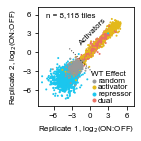

In [6]:
Act_sorted = Act.copy()
Act_sorted['WT Effect'] = np.where(Act_sorted['Effect']=='-', 'random', Act_sorted['Effect'])
Act_sorted['WT Effect'] = pd.Categorical(Act_sorted['WT Effect'], categories=['random', 'activator', 'repressor', 'dual'])

x = [threshA-2, threshA+2]
y = [threshA+2, threshA-2]
ticks = [-6, -3, 0, 3, 6]
reproduce_colors = ['#999999', '#E3B919', '#1BC6EE', '#EA7063']

plt.figure(figsize=(2,2))
sns.scatterplot(data=Act_sorted, x='R1', y='R2', hue='WT Effect', linewidth=0, s=4, palette=sns.color_palette(reproduce_colors))
plt.plot(x, y, ls=':', color='#333333', lw=1)
plt.annotate(xy=(-2, 1), text='Activators', rotation=45)
plt.annotate(xy=(-7.2, 5.5), text=('n = %s tiles' % format(len(Act_sorted), ',d')))
plt.legend(loc='lower right', bbox_to_anchor=(1,0), frameon=False, labelspacing=0, handletextpad=-0.5, borderpad=-0.2,
           title='WT Effect', markerscale=0.5)

plt.xlim(-8.5, 7.2)
plt.xticks(ticks)
plt.yticks(ticks)
plt.ylim(-8.5, 7.2)
plt.xlabel('Replicate 1, log$_2$(ON:OFF)')
plt.ylabel('Replicate 2, log$_2$(ON:OFF)')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHVpert_Activation_reproducibility.png', dpi=1200)

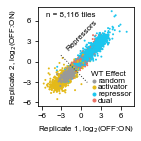

In [7]:
Rep_sorted = Rep.copy()
Rep_sorted['WT Effect'] = np.where(Rep_sorted['Effect']=='-', 'random', Rep_sorted['Effect'])
Rep_sorted['WT Effect'] = pd.Categorical(Rep_sorted['WT Effect'], categories=['random', 'activator', 'repressor', 'dual'])

x = [threshR-2, threshR+2]
y = [threshR+2, threshR-2]
ticks = [-6, -3, 0, 3, 6]
reproduce_colors = ['#999999', '#E3B919', '#1BC6EE', '#EA7063']

plt.figure(figsize=(2,2))
sns.scatterplot(data=Rep_sorted, x='R1', y='R2', hue='WT Effect', linewidth=0, s=4, palette=sns.color_palette(reproduce_colors))
plt.plot(x, y, ls=':', color='#333333', lw=1)
plt.annotate(xy=(-2.5, 1.5), text='Repressors', rotation=45)
plt.annotate(xy=(-5.4, 6.5), text=('n = %s tiles' % format(len(Rep_sorted), ',d')))
plt.legend(loc='lower right', bbox_to_anchor=(1,0), frameon=False, labelspacing=0, handletextpad=-0.5, borderpad=-0.2,
           title='WT Effect', markerscale=0.5)

plt.xlim(-6.5, 8)
plt.xticks(ticks)
plt.yticks(ticks)
plt.ylim(-6.5, 8)
plt.xlabel('Replicate 1, log$_2$(OFF:ON)')
plt.ylabel('Replicate 2, log$_2$(OFF:ON)')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHVpert_Repression_reproducibility.png', dpi=1200)

In [8]:
WT_A = np.mean(list(Act[Act['Type']=='WT']['Standard Error']))
WT_R = np.mean(list(Rep[Rep['Type']=='WT']['Standard Error']))
print('Mean of WT Activation Std Errors: %s' % WT_A)
print('Mean of WT Repression Std Errors: %s' % WT_R)

Mean of WT Activation Std Errors: 0.21506548936633005
Mean of WT Repression Std Errors: 0.1731561095970157


### Perturbation screen validations

In [71]:
df = pd.read_csv('../Flow Single-Cell Data - CSV/HHVpert_Screen_validations_endpoint_single-cell.csv')
df = df[(df['P1']==True) & (df['P2']==True) & (df['mCherry']==True)]
df = df.rename(columns={'Citrine':'Citrine_Act'})
df['Citrine_Rep'] = np.where(df['mCitrine-A']>1e7, True, False)
df.loc[df['Protein'].isna(), 'Protein'] = 'empty' 

aggdf = df.groupby(by=['Reporter', 'Condition', 'Construct', 'Protein', 'Replicate', 'Time'], as_index=False).mean()
aggdf

,Reporter,Condition,Construct,Protein,Replicate,Time,FSC 488/10-A,FSC 488/10-H,SSC 488/10-A,mCherry-A,mCitrine-A,P1,P2,mCherry,Citrine_Act,Citrine_Rep
0,DY032,dox,CL109,EBV EBNA2 (B95-8),Rep1,2.0,8.011471e+08,5.241023e+08,3.367501e+08,7.823060e+07,1.508198e+08,1.0,1.0,1.0,0.932259,0.842341
1,DY032,dox,CL109,EBV EBNA2 (B95-8),Rep2,2.0,8.314875e+08,5.439350e+08,3.357448e+08,7.713868e+07,1.438074e+08,1.0,1.0,1.0,0.931575,0.847232
2,DY032,dox,CL113,VZV VP16,Rep1,2.0,7.520591e+08,4.924653e+08,3.009498e+08,1.057049e+08,9.264276e+07,1.0,1.0,1.0,0.904672,0.798948
3,DY032,dox,CL113,VZV VP16,Rep2,2.0,7.772120e+08,5.122631e+08,2.971269e+08,1.058140e+08,9.001856e+07,1.0,1.0,1.0,0.905974,0.793772
4,DY032,dox,CL114,EBV RTA,Rep1,2.0,7.958771e+08,5.223842e+08,3.124008e+08,7.795502e+07,1.187524e+08,1.0,1.0,1.0,0.931894,0.857194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,JT039,nodox,CL450,KSHV VIRF3,Rep2,5.0,8.226111e+08,5.356869e+08,2.883605e+08,4.273049e+07,6.896695e+07,1.0,1.0,1.0,0.932180,0.883344
220,JT039,nodox,CL451,KSHV VIRF3,Rep1,5.0,9.095007e+08,6.020277e+08,3.917924e+08,1.438580e+08,1.020281e+08,1.0,1.0,1.0,0.979106,0.970186
221,JT039,nodox,CL451,KSHV VIRF3,Rep2,5.0,9.246286e+08,5.872980e+08,3.967420e+08,1.478457e+08,9.824240e+07,1.0,1.0,1.0,0.979645,0.969775
222,JT039,nodox,JT151,Human KRAB,Rep1,5.0,8.930273e+08,5.904874e+08,4.160291e+08,1.711906e+08,1.116728e+08,1.0,1.0,1.0,0.956987,0.936094


In [72]:
constructDict = {'CL144':['Human', 'MYBA', '', ''],
                 'JT151':['Human', 'KRAB', '', ''],
                 'JT126':['', 'empty', '', '']}

dataA = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo_expanded.csv')
dataA['Screen'] = 'Activation'
dataR = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo_expanded.csv')
dataR['Screen'] = 'Repression'
data = pd.concat([dataA, dataR])
key = pd.read_csv('../Flow Single-Cell Data - CSV/HHVpert_validations_key.csv')
key = key[['Construct', 'Tile_ID']].rename(columns={'Tile_ID':'Full Tile ID'})
key = pd.merge(key, data, on='Full Tile ID', how='left')

for i in constructDict:
    key.loc[key['Construct']==i, 'Virus Abbreviation'] = constructDict[i][0]
    key.loc[key['Construct']==i, 'Protein'] = constructDict[i][1]
    key.loc[key['Construct']==i, 'Tile Start'] = constructDict[i][2]
    key.loc[key['Construct']==i, 'Tile End'] = constructDict[i][3]
    
aggdfA = aggdf[aggdf['Reporter']=='DY032']
aggdfA = aggdfA[['Construct', 'Condition', 'Replicate', 'Citrine_Act']]
aggdfA['Citrine OFF'] = 1 - aggdfA['Citrine_Act']

normdf = aggdfA[aggdfA['Condition']=='dox']
normdf['Citrine ON'] = normdf['Citrine_Act']*100
normdf = normdf.groupby(by=['Construct'])['Citrine ON'].agg(['mean', 'std']).reset_index()
normdf = normdf.rename(columns={'mean':'Citrine ON', 'std':'ON std'})
keyA = pd.merge(key, normdf, on='Construct', how='left').drop_duplicates(subset=['Full Tile ID', 'Screen'])

aggdfR = aggdf[aggdf['Reporter']=='JT039']
aggdfR = aggdfR[['Construct', 'Condition', 'Replicate', 'Citrine_Rep']]
aggdfR['Citrine OFF'] = 1 - aggdfR['Citrine_Rep']

normdf = aggdfR[aggdfR['Condition']=='dox']
normdf['Citrine OFF'] = normdf['Citrine OFF']*100
normdf = normdf.groupby(by=['Construct'])['Citrine OFF'].agg(['mean', 'std']).reset_index()
normdf = normdf.rename(columns={'mean':'Citrine OFF', 'std':'OFF std'})

keyR = pd.merge(key, normdf, on='Construct', how='left').drop_duplicates(subset=['Full Tile ID', 'Screen'])
print('Complete')

Complete


<ipython-input-72-3551f5d84137>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normdf['Citrine ON'] = normdf['Citrine_Act']*100
<ipython-input-72-3551f5d84137>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normdf['Citrine OFF'] = normdf['Citrine OFF']*100


#### Activation screen correlation plot featured in Fig. S5F

0.9540322580645161 1.0236308881803934e-16


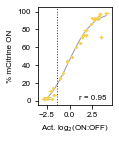

In [61]:
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
# thresh = -np.log(p[0]/(0.4-p[3]) - 1)/p[2] + p[1]
colorA = '#F3CE48' #'#E3B919'

plt.figure(figsize=(1.7,2))
plotDF = keyA[(keyA['Screen']!='Repression') & (~keyA['Citrine ON'].isna()) & (~keyA['Avg'].isna())].sort_values('Avg')

sns.scatterplot(data=plotDF, x='Avg', y='Citrine ON', color=colorA, s=10)
# sns.scatterplot(data=plotDF, x='Avg', y='Norm Citrine ON', color=colorA, s=10)
x = np.array(list(plotDF['Avg']))
y = np.array(list(plotDF['Citrine ON']))
xerr = list(plotDF['Standard Error'])
yerr = list(plotDF['ON std'])
for xi, yi, xe, ye in zip(list(x), list(y), xerr, yerr):
    plt.errorbar(x=xi, y=yi, xerr=xe, yerr=ye, color=colorA, lw=1)

def logistic(x, A, x0, k, off):
    return A/(1 + np.exp(-k*(x-x0)))+off
p, _ = curve_fit(logistic, x, y, p0=[30,6,1,0])
plt.plot(x, logistic(x, *p), color='#999999', lw=1, zorder=0)

coef, p = spearmanr(x, y)
print(coef, p)
plt.annotate('r = ' + str(round(coef, 2)), xy=(4, 0), ha='right', va='bottom')
plt.axvline(x=threshA, ls=':', lw=1, color='#333333')
plt.xlabel('Act. log$_2$(ON:OFF)')
plt.ylabel('% mCitrine ON')
plt.ylim(-5, 105)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHVpert_Act_screen-validation_correlation.png', dpi=1200)


#### Repression screen correlation plot featured in Fig. S5J

0.9661538461538461 4.966365671376562e-15


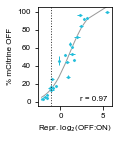

In [62]:
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
colorR = '#23BEDB' #'#1BC6EE'

plt.figure(figsize=(1.7,2))
plotDF = keyR[(keyR['Screen']!='Activation') & (~keyR['Citrine OFF'].isna()) & (~keyR['Avg'].isna())].sort_values('Avg')

sns.scatterplot(data=plotDF, x='Avg', y='Citrine OFF', color=colorR, s=10)
x = np.array(list(plotDF['Avg']))
y = np.array(list(plotDF['Citrine OFF']))
xerr = list(plotDF['Standard Error'])
yerr = list(plotDF['OFF std'])
for xi, yi, xe, ye in zip(list(x), list(y), xerr, yerr):
    plt.errorbar(x=xi, y=yi, xerr=xe, yerr=ye, color=colorR, lw=1)

def logistic(x, A, x0, k, off):
    return A/(1 + np.exp(-k*(x-x0)))+off
p, _ = curve_fit(logistic, x, y, p0=[100,6,1,0])
plt.plot(x, logistic(x, *p), color='#999999', lw=1, zorder=0)

coef, p = spearmanr(x, y)
print(coef, p)
plt.annotate('r = ' + str(round(coef, 2)), xy=(5.5, 0), ha='right', va='bottom')
plt.axvline(x=threshR, ls=':', lw=1, color='#333333')
plt.xlabel('Repr. log$_2$(OFF:ON)')
plt.ylabel('% mCitrine OFF')
plt.ylim(-5, 105)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHVpert_Rep_screen-validation_correlation.png', dpi=1200)


#### All validation flow cytometry distributions (not featured in a figure panel)

In [35]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

def plot_validations(df, screentype, key):
    if screentype == 'Activation':
        reporter = 'DY032'
        color = '#F3CE48'
        yvar = 'Citrine ON'
#         yvar = 'Citrine_Act'
        opposite = 'Repression'
        cutoff = 3e6
    elif screentype == 'Repression':
        reporter = 'JT039'
        color = '#23BEDB'
        yvar = 'Citrine OFF'
#         yvar = 'Citrine_Rep'
        opposite = 'Activation'
        cutoff = 1e7
    
    df = df[df['Reporter']==reporter]
    df['mCitrine'] = np.log10(df['mCitrine-A'])
    df = df.drop(columns='Protein')
    df = pd.merge(df, key[['Construct', 'Avg', 'Virus Abbreviation', 'Protein', 'Mutation', 'Tile Start', 'Tile End', yvar, 'Screen']], how='left', on='Construct')
    df.loc[df['Avg'].isna(), 'Avg'] = -10
    df['Condition'] = pd.Categorical(df['Condition'], categories=['nodox', 'dox'], ordered=True)
    df = df.sort_values(by=['Avg', 'Condition', 'Replicate'], ascending=[False, True, True])
    df['Condition-Replicate'] = df['Condition'].astype(str) + '-' + df['Replicate']

    labeldf = df[df['Screen']!=opposite].sort_values(by=['Avg'], ascending=False)
    labeldf = labeldf[['Construct', 'Virus Abbreviation', 'Protein', 'Mutation', 'Tile Start', 'Tile End', yvar, 'Avg']].drop_duplicates()
    labeldf['Tile Start'] = np.where(labeldf['Tile Start']=='', labeldf['Tile Start'], labeldf['Tile Start'].astype(str).str.split('.').str[0])
    labeldf['Tile End'] = np.where(labeldf['Tile End']=='', labeldf['Tile End'], labeldf['Tile End'].astype(str).str.split('.').str[0])
    labeldf['Sample'] = np.where(labeldf['Tile Start']=='', labeldf['Virus Abbreviation'] + ' ' + labeldf['Protein'],
                             labeldf['Virus Abbreviation'] + ' ' + labeldf['Protein'] + ' ' + labeldf['Mutation'] + '\n[' \
                             + labeldf['Tile Start'] + '-' + labeldf['Tile End'] + ']')

    samples = dict(zip(list(labeldf['Construct']), list(labeldf['Sample'])))
    df['Sample'] = df['Construct'].map(samples)
    df = df[df['Screen']!=opposite].sort_values(by=['Avg', 'Condition', 'Replicate'], ascending=[False, True, True])
#     print(df)
    
    if screentype == 'Activation':
        ON = list(labeldf[yvar])
        ON = [round(on, 1) for on in ON]
        OFF = [str(round(100-on, 1)) + '%' for on in ON]
        ON = [str(on) + '%' for on in ON]
        
    elif screentype == 'Repression':
        OFF = list(labeldf[yvar])
        OFF = [round(off, 1) for off in OFF]
        ON = [str(round(100-off, 1)) + '%' for off in OFF]
        OFF = [str(off) + '%' for off in OFF]
        
    pal = sns.color_palette(['#999999', '#999999', color, color])
    
    g = sns.FacetGrid(data=df, col='Sample', col_wrap=6,
                      hue='Condition-Replicate', palette=pal,
                      aspect=1, height=1.25)
    g.map(sns.kdeplot, 'mCitrine', fill=True, bw_adjust=0.2)
    g.map(plt.axvline, x=np.log10(cutoff), ls=':', color='#333333', lw=1)
    g.set_titles(template='{col_name}')
    plt.xlim([4.5,9.5])
    plt.ylim([0,4])
    plt.xticks([5, 6, 7, 8, 9], ['10$^5$', '10$^6$', '10$^7$', '10$^8$', '10$^9$'])
    for ax, on, off in zip(g.axes.flat, ON, OFF):
        ax.text(0.05, 0.95, off, transform=ax.transAxes, ha='left', va='top')
        ax.text(0.95, 0.95, on, transform=ax.transAxes, ha='right', va='top')
#         ax.set_xlabel('mCitrine')
        ax.grid(False)
    plt.savefig('../Individual Figure Panels/Figure S5/HHVpert_%s_validations_kdeplot.png' % screentype, dpi=1200)
    plt.close()

plot_validations(df, 'Activation', keyA)
plot_validations(df, 'Repression', keyR)
print('Complete')

<ipython-input-35-6e0410464d6f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])
<ipython-input-35-6e0410464d6f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


Complete


#### Separate multi-plot figures, grouped by protein so that WT and mutants are together (not featured in a figure panel)

In [84]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

def plot_validations_subset(df, screentype, key, protein):
    if screentype == 'Activation':
        reporter = 'DY032'
        color = '#F3CE48'
        yvar = 'Citrine ON'
#         yvar = 'Citrine_Act'
        opposite = 'Repression'
        cutoff = 3e6
    elif screentype == 'Repression':
        reporter = 'JT039'
        color = '#23BEDB'
        yvar = 'Citrine OFF'
#         yvar = 'Citrine_Rep'
        opposite = 'Activation'
        cutoff = 1e7
    
    if protein == 'KSHV VIRF4':
        df = df[df['Construct']!='CL452']
    df = df[(df['Reporter']==reporter) & (df['Protein']==protein)]
    df['mCitrine'] = np.log10(df['mCitrine-A'])
    df = df.drop(columns='Protein')
    df = pd.merge(df, key[['Construct', 'Avg', 'Virus Abbreviation', 'Protein', 'Mutation', 'Tile Start', 'Tile End', yvar, 'Screen']], how='left', on='Construct')
    df.loc[df['Avg'].isna(), 'Avg'] = -10
    df['Condition'] = pd.Categorical(df['Condition'], categories=['nodox', 'dox'], ordered=True)
    df = df.sort_values(by=['Avg', 'Condition', 'Replicate'], ascending=[False, True, True])
    df['Condition-Replicate'] = df['Condition'].astype(str) + '-' + df['Replicate']

    labeldf = df[df['Screen']!=opposite].sort_values(by=['Avg'], ascending=False)
    labeldf = labeldf[['Construct', 'Virus Abbreviation', 'Protein', 'Mutation', 'Tile Start', 'Tile End', yvar, 'Avg']].drop_duplicates()
    labeldf['Tile Start'] = np.where(labeldf['Tile Start']=='', labeldf['Tile Start'], labeldf['Tile Start'].astype(str).str.split('.').str[0])
    labeldf['Tile End'] = np.where(labeldf['Tile End']=='', labeldf['Tile End'], labeldf['Tile End'].astype(str).str.split('.').str[0])
    labeldf['Sample'] = np.where(labeldf['Tile Start']=='', labeldf['Virus Abbreviation'] + ' ' + labeldf['Protein'],
                             labeldf['Virus Abbreviation'] + ' ' + labeldf['Protein'] + ' ' + labeldf['Mutation'] + '\n[' \
                             + labeldf['Tile Start'] + '-' + labeldf['Tile End'] + ']')

    samples = dict(zip(list(labeldf['Construct']), list(labeldf['Sample'])))
    df['Sample'] = df['Construct'].map(samples)
    mutorder = list(set(list(df['Mutation'])))
    mutorder = ['WT'] + [m for m in mutorder if m != 'WT']
    df['Mutation'] = pd.Categorical(df['Mutation'], categories=mutorder, ordered=True)
    labeldf['Mutation'] = pd.Categorical(labeldf['Mutation'], categories=mutorder, ordered=True)
    labeldf = labeldf.sort_values(by='Mutation')
    df = df[df['Screen']!=opposite].sort_values(by=['Mutation', 'Tile Start', 'Construct', 'Condition', 'Replicate'])
    
    if screentype == 'Activation':
        ON = list(labeldf[yvar])
        ON = [round(on, 1) for on in ON]
        OFF = [str(round(100-on, 1)) + '%' for on in ON]
        ON = [str(on) + '%' for on in ON]
        
    elif screentype == 'Repression':
        OFF = list(labeldf[yvar])
        OFF = [round(off, 1) for off in OFF]
        ON = [str(round(100-off, 1)) + '%' for off in OFF]
        OFF = [str(off) + '%' for off in OFF]
        
    pal = sns.color_palette(['#999999', '#999999', color, color])
    if len(df) == 0:
        return None
    g = sns.FacetGrid(data=df, col='Sample',
                      hue='Condition-Replicate', palette=pal,
                      aspect=0.8333, height=1.5)
    g.map(sns.kdeplot, 'mCitrine', fill=True, bw_adjust=0.2)
    g.map(plt.axvline, x=np.log10(cutoff), ls=':', color='#333333', lw=1)
    if protein == 'KSHV VIRF2':
        for i, ax in zip(range(2), g.axes.flatten()):
            if i == 0:
                ax.set_title('WT', pad=0.5, fontsize=8)
            elif i == 1:
                ax.set_title('\u0394L321-S325', pad=0.5, fontsize=8)
        plt.suptitle('KSHV VIRF2 [301-380]', y=0.88, fontsize=8)
    elif protein == 'KSHV VIRF4':
        for i, ax in zip(range(2), g.axes.flatten()):
            if i == 0:
                ax.set_title('WT', pad=0.5, fontsize=8)
            elif i == 1:
                ax.set_title('W671A', pad=0.5, fontsize=8)
        plt.suptitle('KSHV VIRF4 [611-690]', y=0.88, fontsize=8)
    else:        
        g.set_titles(template='{col_name}')
    plt.xlim([4.5,9.5])
    plt.ylim([0,4.5])
    plt.xticks([5, 6, 7, 8, 9], ['10$^5$', '10$^6$', '10$^7$', '10$^8$', '10$^9$'])
    for ax, on, off in zip(g.axes.flat, ON, OFF):
        ax.text(0.05, 0.95, off, transform=ax.transAxes, ha='left', va='top')
        ax.text(0.95, 0.95, on, transform=ax.transAxes, ha='right', va='top')
        ax.grid(False)
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure S5/validation_subsets/HHVpert_%s_%s_subset_validations_kdeplot.png' % (screentype, '-'.join(protein.split(' '))), dpi=1200)
    plt.close()

keyA2 = keyA[keyA['Effect']!='repressor']
keyA2['Protein'] = keyA2['Virus Abbreviation'] + ' ' + keyA2['Protein']
protA = set(keyA2['Protein'])
for a in protA:
    print(a)
    plot_validations_subset(df, 'Activation', keyA, a)

keyR2 = keyR[keyR['Effect']!='activator']
keyR2['Protein'] = keyR2['Virus Abbreviation'] + ' ' + keyR2['Protein']
protR = set(keyR2['Protein'])
for r in protR:
    print(r)
    plot_validations_subset(df, 'Repression', keyR, r)
print('Complete')

<ipython-input-84-4f1cd2d5dd84>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keyA2['Protein'] = keyA2['Virus Abbreviation'] + ' ' + keyA2['Protein']
<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


EBV UL95
KSHV ORF10


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


KSHV VIRF2


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


VZV VP16


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


KSHV VIRF4
HHV6A U95
HCMV IE2


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


EBV RTA


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


KSHV VIRF3
Human MYBA


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


EBV MTP


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


EBV EBNA2
KSHV DBP


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])
<ipython-input-84-4f1cd2d5dd84>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keyR2['Protein'] = keyR2['Virus Abbreviation'] + ' ' + keyR2['Protein']


EBV UL95
KSHV KbZIP


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


Human KRAB


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


HHV7 U84


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


HCMV UL29


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


KSHV VIRF2


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


EBV EBNA3
HCMV UL82


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


HHV6A U95
HCMV IE2


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


EBV RTA


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


KSHV VIRF3


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


HCMV RL5A


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


EBV MTP


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


HSV1 US3


<ipython-input-84-4f1cd2d5dd84>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mCitrine'] = np.log10(df['mCitrine-A'])


Complete


#### Barplot summaries of activation and repression validations featured in Fig. S5E & S5I

Complete


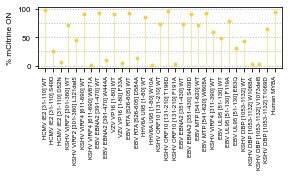

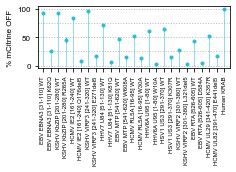

In [92]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

def plot_validation_summary(df, screentype):
    if screentype == 'Activation':
        reporter = 'DY032'
        color = '#F3CE48'
        meancol = 'Citrine ON'
        stdcol = 'ON std'
        xlabel = '% mCitrine ON'
        opposite = 'Repression'
        cutoff = 3e6
#         dims = [2.5, 3.8]
        dims = [4.06, 2.5]
    elif screentype == 'Repression':
        reporter = 'JT039'
        color = '#23BEDB'
        meancol = 'Citrine OFF'
        stdcol = 'OFF std'
        xlabel = '% mCitrine OFF'
        opposite = 'Activation'
        cutoff = 1e7
#         dims = [2.42, 3.14]
        dims = [3.33, 2.44]
    
    df = df[(df['Screen']==screentype) & (~df[meancol].isna())].sort_values(by='Avg', ascending=False)
    df['Tile Start'] = np.where(df['Tile Start']=='', df['Tile Start'], df['Tile Start'].astype(str).str.split('.').str[0])
    df['Tile End'] = np.where(df['Tile End']=='', df['Tile End'], df['Tile End'].astype(str).str.split('.').str[0])
    df['Sample'] = np.where(df['Tile Start']=='', df['Virus Abbreviation'] + ' ' + df['Protein'],
                             df['Virus Abbreviation'] + ' ' + df['Protein'] + ' [' \
                             + df['Tile Start'] + '-' + df['Tile End'] + ']')
    
    wtorder = list(df[df['Mutation']=='WT']['Sample'])
    orderDict = dict(zip(wtorder, range(len(wtorder))))
    df['Order'] = df['Sample'].map(orderDict)
    df['Sample'] = np.where(df['Mutation']!='-', df['Sample'] + ' ' + df['Mutation'], df['Sample'])
    df = df.sort_values(by=['Order', 'Mutation'], ascending=[True, False])
    
    samplelist = list(df['Sample'])
    ticklist = list(range(len(samplelist)))
    meanlist = list(df[meancol])
    stdlist = list(df[stdcol])
    
#     fig, ax = plt.subplots(figsize=dims)
#     for s, t, m, sd in zip(samplelist, ticklist, meanlist, stdlist):
#         ax.plot([0, m], [t, t], color=color, lw=0.5)
#         ax.plot(m, t, marker='o', markersize=3, color=color)
#         ax.errorbar(x=m, y=t, xerr=sd, lw=1, color=color)
#     ax.set_xlabel(xlabel)
#     ax.set_xticks(ticks=[0, 50, 100])
#     for x in range(0, 101, 25):
#         ax.axvline(x=x, ls=':', lw=1, color='#BBBBBB', zorder=-10)
#     ax.set_yticks(ticks=ticklist)
#     ax.set_yticklabels(labels=samplelist, fontsize=6)
#     ax.set_ylim(ax.get_ylim()[0] + 0.5, ax.get_ylim()[1] - 0.5)
#     ax.invert_yaxis()
#     plt.tight_layout()
#     plt.savefig('../Individual Figure Panels/Figure S5/vTR_%s_validation_summary.png' % screentype, dpi=1200)

    fig, ax = plt.subplots(figsize=dims)
    for s, t, m, sd in zip(samplelist, ticklist, meanlist, stdlist):
        ax.plot([t, t], [0, m], color=color, lw=0.5)
        ax.plot(t, m, marker='o', markersize=3, color=color)
        ax.errorbar(y=m, x=t, yerr=sd, lw=1, color=color)
    ax.set_ylabel(xlabel)
    ax.set_yticks(ticks=[0, 50, 100])
    for x in range(0, 101, 25):
        ax.axhline(y=x, ls=':', lw=1, color='#BBBBBB', zorder=-10)
    ax.set_xticks(ticks=ticklist)
    ax.set_xticklabels(labels=samplelist, fontsize=6, rotation=90)
    ax.set_xlim(ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5)
#     ax.invert_xaxis()
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure S5/vTR_%s_validation_summary_wide.png' % screentype, dpi=1200)
        
plot_validation_summary(keyA, 'Activation')
plot_validation_summary(keyR, 'Repression')
print('Complete')

### Tiling plots of domains with all perturbations mapped - add EBNA2 and SCAF back in (WT dropped out)

In [65]:
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

jpred4 = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/jpred4_results_summarized.csv').drop(columns='Protein Sequence')
dropoutDict = {'P12978_010':'PPPPPPPPPPQRRDAWTQEPSPLDRDPLGYDVGHGPLASAMRMLWMANYIVRQSRGDRGLILPQGPQTAPQARLVQPHVP',
               'P52351_041':'TKKKKRYREDDDRELTKDKNDIKELVDAIGMLRHEISALKYIRSQSPQRQHCTAVDTMPTIEEKNVASPKPSVVNASLTP'}
coords = {'P12978_010':[91, 170], 'P52351_041':[401, 480]}
estWT = {'P12978_010':146, 'P52351_041':446}

# generate tiling plots containing all info and sequence
def tiling_plot(df, effect_type, thresh, structure):
    # set variables based on effect type
    if effect_type == 'activator':
        color = '#D7AC00'
        ylabel = 'log$_2$(ON:OFF) Activation Score'
        savedir = '../Individual Figure Panels/HHV_Activator_perturbations'
        sigma2 = 2*WT_A
        
    elif effect_type == 'repressor':
        color = '#23BEDB'
        ylabel = 'log$_2$(OFF:ON) Repression Score'
        savedir = '../Individual Figure Panels/HHV_Repressor_perturbations'
        sigma2 = 2*WT_R
    
    # check if output directory exists - if not, make directory
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    
    # subset dataframe to focus on those with correct activity, determine y-limits, and get list of tile identifiers
    df = pd.merge(df, structure, on='Tile ID', how='left')
    df = df[df['Effect'].isin([effect_type, 'dual'])]
    ymax = max(list(df['R1']) + list(df['R2']))*1.05
    ymin = min(list(df['R1']) + list(df['R2']))*1.05
    tileList = list(set(list(df[df['Tile ID']!='-']['Tile ID'])))
    
    # for each tile, create plot with effect of all perturbations
    for tile in tileList:
        tempdf = df[df['Tile ID']==tile]
        # if WT sequence not in the subsetted dataframe, then estimate WT activity
        if 'WT' not in list(tempdf['Type']):
            virus = list(tempdf['Virus Abbreviation'])[0]
            protein = list(tempdf['Protein'])[0]
            print('No WT measurement for %s %s (%s)' % (virus, protein, tile))
            WT_avg = np.mean(list(tempdf[tempdf['Position']>estWT[tile]]['Avg']))
            WT_vals = [WT_avg + sigma2, WT_avg - sigma2]
            WT_seq = dropoutDict[tile]
            WT_struct = list(tempdf['Structure'])[0]
            start = coords[tile][0]
            end = coords[tile][1] + 1
            
        else:
            # extract information about WT sequence: virus, protein, scores for each replicate, sequence, and coordinates
            virus = list(tempdf[tempdf['Type']=='WT']['Virus Abbreviation'])[0]
            protein = list(tempdf[tempdf['Type']=='WT']['Protein'])[0]
            WT_avg = list(tempdf[tempdf['Type']=='WT']['Avg'])[0]
            WT_vals = [WT_avg + sigma2, WT_avg - sigma2]
            WT_seq = list(tempdf[tempdf['Type']=='WT']['Protein Sequence'])[0]
            WT_struct = list(tempdf[tempdf['Type']=='WT']['Structure'])[0]
            start = int(list(tempdf[tempdf['Type']=='WT']['Tile Start'])[0])
            end = int(list(tempdf[tempdf['Type']=='WT']['Tile End'])[0]) + 1
        xticks = list(range(start, end, 1))
        xticks_mod = [x - 0.5 for x in xticks]
        xrange = list(range(start, end+1, 5))

        if type(WT_struct) == float:
            print('No structural information for %s %s (%s)' % (virus, protein, tile))
            continue
        
        # create dataframes for specific subplots
        struct_dict = {'-':'#FFFFFF', 'E':'#555555', 'H':'#AAAAAA'}
        WT_struct = [struct_dict[s] for s in WT_struct if s in struct_dict]
        struct_df = pd.DataFrame(index=xticks, data={'JPred4':list(WT_struct)}).T
        
        deletion = tempdf[tempdf['Type']=='deletion']
        deletion = deletion.sort_values(by='Position')
        delx = [p + 2 for p in list(deletion['Position'])]
        dely = list(deletion['Avg'])
        delyerr = list(deletion['Standard Error'])
        
        subs = tempdf[tempdf['Type']=='substitution']
        subs = subs.sort_values(by='Position')
        subx = list(subs['Position'])
        suby = list(subs['Avg'])
        subyerr = list(subs['Standard Error'])
        subaa = list(subs['Perturbation'])
        sub_nonhit = list(subs[subs['Hit']==0]['Position'])
        
        # initialize plots
        fig, ax = plt.subplots(3, 1, figsize=(8.65,3), gridspec_kw={'height_ratios':[0.75, 1.25, 18]}, sharex=False)
        plt.subplots_adjust(hspace=0.03)
        
        ax[0].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
        ax[0].set_xticks([])
        ax[0].set_ylim(1,2)
        ax[0].set_yticks([])
        ax[0].set_ylabel('', rotation=0, va='center', ha='right')
        sns.despine(left=True, bottom=True, ax=ax[0])
        for s, x in zip(list(WT_struct), xticks_mod):
            ax[0].add_patch(Rectangle((x, 1), 1, 1, edgecolor=s, facecolor=s))
            
        custom_patch = [Line2D([0], [0], color='#555555', marker='s', lw=0),
                        Line2D([0], [0], color='#AAAAAA', marker='s', lw=0)]
        ax[0].legend(custom_patch, ['Extended', 'Helix'], loc='upper right',
                     bbox_to_anchor=(0, 2), frameon=False, handletextpad=-0.2,
                     labelspacing=0.1, borderpad=0, title='JPred4', title_fontsize=8)
        
        
        # plot sequence on top with critical substitutions highlighted
        ax[1].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
        ax[1].xaxis.set_major_locator(MultipleLocator(5))
        ax[1].xaxis.set_minor_locator(MultipleLocator(1))
        ax[1].xaxis.set_ticklabels('')
        ax[1].set_ylim(0,2)
        ax[1].set_yticks([])
        sns.despine(left=True, bottom=True, ax=ax[1])
        
        for x, aa in zip(xticks, WT_seq):
            if x in sub_nonhit:
                ax[1].annotate(text=aa, xy=(x, 1), va='center', ha='center', size=7, color='#EA7063')
            else:
                ax[1].annotate(text=aa, xy=(x, 1), va='center', ha='center', size=7)
                
        # plot deletion scan data, with WT scores as horizontal span
        ax[2].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
        ax[2].xaxis.set_major_locator(MultipleLocator(5))
        ax[2].xaxis.set_minor_locator(MultipleLocator(1))
        ax[2].set_ylim(ymin, ymax)
        ax[2].axhline(y=thresh, color='#333333', ls=':', zorder=-5, lw=1)
#         if 'WT' in list(tempdf['Type']):
        ax[2].axhspan(ymax=WT_vals[0], ymin=WT_vals[1], color=color, alpha=0.25, zorder=-2)
        ax[2].axhline(y=WT_avg, color=color, ls=':', zorder=-1, lw=1)
        
        for x in xrange:
            ax[2].axvline(x=x-0.5, color='#DDDDDD', ls=':', lw=1)
        
        plotdf_del = pd.DataFrame({'X':delx, 'Y':dely})
        sns.scatterplot(data=plotdf_del, x='X', y='Y', color=color, ax=ax[2], linewidth=0)
        for x, y, ye in zip(delx, dely, delyerr):
            ax[2].errorbar(x, y, xerr=2.5, yerr=ye, color=color, zorder=100)
        
        # plot substitution data
        for x, y, aa in zip(subx, suby, subaa):
            ax[2].annotate(text=aa, xy=(x, y), va='center', ha='center', size=7, color=color) #'#666666')
        
        ax[2].set_xlabel('Residue Position along Protein')
        ax[2].set_ylabel(ylabel)
        
        title = virus + ' ' + protein + ' (' + tile + ')\n\n'
        savename = '_'.join([virus, protein, tile, effect_type, 'perturb.png'])
        plt.title(title)
        plt.savefig(os.path.join(savedir, savename), dpi=1200, bbox_inches='tight')
        plt.close()

tiling_plot(Act, 'activator', threshA, jpred4)
tiling_plot(Rep, 'repressor', threshR, jpred4)
print('Complete')

No structural information for KSHV RTA (F5HCV3_060)
No WT measurement for HHV7 SCAF (P52351_041)
No WT measurement for EBV EBNA2 (P12978_010)
Complete


### END

### Archived motif finding (9/26/2022)

In [6]:
# motifs = {'ZNF':'C.{2,4}C.{3}.[LIVMFYWC].{8}H.{3,5}H', # check to make sure this is correct syntax <-- this is C2H2
#           'K9K27':'RKS',
#           'SUMO_SIM_anti':'[DEST]{1,10}.{0,1}[VIL][DESTVILMA][VIL][VILM].[DEST]{0,5}', # prob: 0.0023495
#           'SUMO_SIM_par':'[DEST]{0,5}.[VILPTM][VIL][DESTVILMA][VIL].{0,1}[DEST]{1,10}',
#           'SUMO_for':'[VILMAFP](K).E',
#           'SUMO_rev':'[SDE].{0,5}[DE].(K).{0,1}[AIFLMPSTV]',
#           'HP1':'P[MVLIRWY]V[MVLIAS][LM]', # prob: 0.0000338
#           'HOMEOBOX':'[FY][DEP]WM',
#           'WRPW1':'[WFY]RP[WFY].{0,7}$', # prob: 1.333e-07
#           'WRPW2':'[WFY][KR]P[WFY]',
#           'LSD1':'^M{0,1}PR.FLV[KR]K{0,1}.', # prob: 8.862e-11
# #           'CtBP_canonical':'(P[LVIPME][DENS][LM][VASTRG])|(G[LVIPME][DENS][LM][VASTRG]((K)|(.[KR])))', # prob: 0.0001173
#           'CtBP_expanded':'P.[DENS][LM].',
#           'CtBP_EBNA3':'LDLS',
#           'Sin3A_SID':'AA..L',
#           'EH1':'FSI..I',
#           'NCoR_SMRT_1':'P.K.R',
#           'NCoR_SMRT_2':'HKKF',
#           'LIG_NRBOX':'[^P]L[^P][^P]LL[^P]',
# #           'NR_box_rev':'LL..L',
#           'pseudo_NRBOX':'([^P][VIWFY][^P][^P][VLIWFY][VLIWFY][^P])|([^P][VLIWFY][^P][^P][VIWFY][VLIWFY][^P])|([^P][VLIWFY][^P][^P][VLIWFY][VIWFY][^P])',
# #           'pseudo_NRBOX':'([^P][VIWFYM][^P][^P][VLIWFYM][VLIWFYM][^P])|([^P][VLIWFYM][^P][^P][VIWFYM][VLIWFYM][^P])|([^P][VLIWFYM][^P][^P][VLIWFYM][VIWFYM][^P])',
# #           'pseudo_NRBOX':'([VIWFY]..[VLIWFY][VLIWFY])|([VLIWFY]..[VIWFY][VLIWFY])|([VLIWFY]..[VLIWFY][VIWFY])',
#           'K4':'AR[ST]K',
#           'Rb_LxCxE_1':'([DEST]|^).{0,4}[LI].C.E.{1,4}[FLMIVAWPHY].{0,8}([DEST]|$)',
#           'Rb_LxCxE_2':'[LI].C.[DE]',
#           'Rb_pABgroove_1':'..[LIMV]..[LM][FY]D.',
#           'LIG_CORNRBOX':'L[^P]{2,2}[HI]I[^P]{2,2}[IAV][IL]', # prob: 0.0000010
#           'CBX':'[NQD][VI][VISF][IV]TD[VI]T[YVTSA][DNG][RLGC][LKV][VT]VT[VIF][RK]E[CYF]',
#           'MYND_1':'P.L.P',
#           'MYND_2':'PP.LI',
#           'MYND_3':'[LMV]P.LE',
#           'USP7_CTD':'K...K',
#           'USP7_MATH_2':'P.E[^P].S[^P]',
#           'USP7_MATH_1':'[PA][^P][^FYWIL]S[^P]',
#           'DCNL_PONY_1':'^M[MIL].[MIL]',
#           'CSL_BTD_1':'[AFILMPTVW]W[FHILMPSTVW]P',
#           'CYCLIN_RxL_1':'(.|([KRH].{0,3}))[^EDWNSG][^D][RK][^D]L.{0,1}[FL].{0,3}[EDST]',
#           'IRF3_LxIS_1':'[VILPF].{1,3}L.I(S)',
#           'WRPW_1':'[WFY]RP[WFY].{0,7}$',
#           'WRPW_2':'[WFY][KR]P[WFY]',
#           'WW_1':'PP.Y',
#           'WW_2':'PPLP',
#           'WW_3':'.PPR.'
#          }

In [7]:
# ### PROTEIN LEVEL
# import re
# uID_to_gene_df = pd.read_csv('uID_protein_virus_mapping_HHV_expanded.csv')
# uID_to_gene_df = uID_to_gene_df.rename(columns={'Protein ID':'UniProt ID'})
# uID_to_gene_df = uID_to_gene_df.append({'UniProt ID':'fiducial', 'Virus':'', 'Protein':''}, ignore_index=True)
# uID_to_gene_df = uID_to_gene_df.append({'UniProt ID':'random', 'Virus':'', 'Protein':''}, ignore_index=True)

# allprot = pd.read_csv('../herpesvirus_uniref90/uniref_reviewed_HHV+SuHV.csv')
# protlen = sum(list(allprot['Length']))
# allprot = allprot[['Cluster ID', 'Representative Sequence']].rename(columns={'Cluster ID':'Protein ID', 'Representative Sequence':'Sequence'})

# for m in motifs:
# #     allprot[m] = np.where(allprot['Sequence'].str.contains(motifs[m]), 1, 0) # sequence can contain any number of instances
#     allprot[m] = [len(re.findall(motifs[m], s)) for s in list(allprot['Sequence'])] # counts ALL instances
    
# motifList = []
# countList = []
# for c in allprot.columns[2:]:
#     motifList.append(c)
#     countList.append(sum(list(allprot[c])))

# allprot = pd.DataFrame({'Motif':motifList, 'Proteome':countList})
# # allprot['Prot FPK'] = 1000*allprot['Proteome']/protlen
# # allprot

In [8]:
# ### EXPANDED, MAX-TILE, AND PERTURBED DOMAINS
# alldoms = pd.read_csv('Screen_Files/HHV/HHV_domains.csv')
# maxtiles = pd.read_csv('Screen_Files/HHV/HHV-perturb_max-tiles.csv')
# maxtiles['Perturbed'] = 1
# maxtiles = maxtiles[['Tile Sequence', 'Perturbed']].rename(columns={'Tile Sequence':'Max Sequence'})
# alldoms = pd.merge(alldoms, maxtiles, on=['Max Sequence'], how='outer')
# alldoms['Perturbed'] = alldoms['Perturbed'].fillna(0)

# def dom_motif(df, effect, extmax, perturbed=0):
#     df = df[df['Effect']==effect]
#     if extmax == 'ext':
#         domlen = sum(list(df['Extended Length']))
#         seqtype = 'Extended Sequence'
#     elif extmax == 'max':
#         domlen = 80
#         seqtype = 'Max Sequence' 
#     if perturbed == 1:
#         df = df[df['Perturbed']==1]
    
#     df = df[['Protein ID', seqtype]].rename(columns={seqtype:'Sequence'})
#     for m in motifs:            
# #         df[m] = np.where(df['Sequence'].str.contains(motifs[m]), 1, 0)
#         df[m] = [len(re.findall(motifs[m], s)) for s in list(df['Sequence'])]

#     motifList = []
#     countList = []
#     for c in df.columns[2:]:
#         motifList.append(c)
#         countList.append(sum(list(df[c])))

#     df = pd.DataFrame({'Motif':motifList, effect:countList})
# #     df[effect[:3] + ' FPK'] = 1000*df[effect]/domlen
#     return df, domlen

# # extended effector domains (all 200+)
# actdoms_ext, actlen_ext = dom_motif(alldoms, 'Activation', 'ext')
# repdoms_ext, replen_ext = dom_motif(alldoms, 'Repression', 'ext')

# # maximum-strength tile within effector domain (all 200+)
# actdoms_max, actlen_max = dom_motif(alldoms, 'Activation', 'max')
# repdoms_max, replen_max = dom_motif(alldoms, 'Repression', 'max')

# # maximum-strength tile of the perturbed domains (<100)
# actdoms_pert, actlen_pert = dom_motif(alldoms, 'Activation', 'max', perturbed=1)
# repdoms_pert, replen_pert = dom_motif(alldoms, 'Repression', 'max', perturbed=1)

# # maximum-strength tile of the perturbed domains, same input dataframe (<100)
# actdoms_same, actlen_same = dom_motif(Adom, 'Activation', 'max')
# repdoms_same, replen_same = dom_motif(Rdom, 'Repression', 'max')

# # merge altogether
# motifDF = pd.merge(allprot, actdoms_ext, how='outer', on='Motif')
# motifDF = pd.merge(motifDF, repdoms_ext, how='outer', on='Motif')
# motifDF = motifDF.rename(columns={'Activation':'Extended Activation (all)', 'Repression':'Extended Repression (all)'})

# motifDF = pd.merge(motifDF, actdoms_max, how='outer', on='Motif')
# motifDF = pd.merge(motifDF, repdoms_max, how='outer', on='Motif')
# motifDF = motifDF.rename(columns={'Activation':'Activation (all)', 'Repression':'Repression (all)'})

# # motifDF = pd.merge(motifDF, actdoms_pert, how='outer', on='Motif')
# # motifDF = pd.merge(motifDF, repdoms_pert, how='outer', on='Motif')

# motifDF = pd.merge(motifDF, actdoms_same, how='outer', on='Motif')
# motifDF = pd.merge(motifDF, repdoms_same, how='outer', on='Motif')

# motifDF['Non-effector'] = motifDF['Proteome'] - motifDF['Activation'] - motifDF['Repression']
# motifDF2 = motifDF.copy()
# # motifDF2

# # motifDF['Act FPK'] = 1000*motifDF['Activation']/actlen
# # motifDF['Rep FPK'] = 1000*motifDF['Repression']/replen
# # motifDF['Non FPK'] = 1000*motifDF['Non-effector']/(protlen - actlen - replen)

# # motifDF['Act/Non'] = np.log2(motifDF['Act FPK']/motifDF['Non FPK'])
# # motifDF['Rep/Non'] = np.log2(motifDF['Rep FPK']/motifDF['Non FPK'])
# # motifDF.sort_values(by='Act/Non', ascending=False)

# # fig, ax = plt.subplots(2, 1, figsize=(4,8))
# # sns.barplot(data=motifDF[(motifDF['Act/Non']<3) & (motifDF['Act/Non']>-3)].sort_values(by='Act/Non', ascending=False), y='Motif', x='Act/Non', ax=ax[0])
# # ax[0].set_xlim(-3,3)
# # sns.barplot(data=motifDF[(motifDF['Rep/Non']<3) & (motifDF['Rep/Non']>-3)].sort_values(by='Rep/Non', ascending=False), y='Motif', x='Rep/Non', ax=ax[1])
# # ax[1].set_xlim(-3,3)

### Archived Modified Motif Finding (10/1/2022)

In [315]:
### FIRST PASS: motif search in noeffect/enhancing vs reducing/breaking will tell us which motifs are relevant
### i.e. if a motif appears more often in non-essential region, then this will still be reported but will
###      not factor into the final analysis

In [9]:
# import re

# def motif_search(tilelist, seqlist, effect, coordlist=[]):
#     if len(coordlist) != 0:
#         df = pd.DataFrame({'Protein ID':[u.split('_')[0] for u in tilelist],
#                            'Essential Sequence':seqlist,
#                            'Ext Start':coordlist[0],
#                            'Ext End':coordlist[1],
#                            'Start':coordlist[2],
#                            'End':coordlist[3]})
#         numcols = 6
#         for m in motifs:
#             motifcounts = []
#             for t, q, es, ee, s, e in zip(tilelist, list(df['Essential Sequence']), list(df['Ext Start']),
#                                           list(df['Ext End']), list(df['Start']), list(df['End'])):
#                 matches = re.findall(motifs[m], q)
#                 counter = 0
#                 if len(matches) != 0:
#                     for i in matches:
#                         if type(i) == tuple:
#                             for ii in i:
#                                 if len(ii) != 0:
#                                     i = ii
#                         i_start = re.search(i, q).start()
#                         i_start += es
#                         i_end = i_start + len(i) - 1
#                         if (i_end < s) | (i_start > e):
#                             continue
#                         else:
#                             counter += 1
#                 motifcounts.append(counter)
#             df[m] = motifcounts
    
#     else:
#         df = pd.DataFrame({'Protein ID':[u.split('_')[0] for u in tilelist], 'Essential Sequence':seqlist})
#         df = df['Essential Sequence'].str.split(expand=True).stack().reset_index(level=1, drop=True).reset_index(name='Essential Sequence')
#         for m in motifs:
#             df[m] = [len(re.findall(motifs[m], s)) for s in list(df['Essential Sequence'])]
#         df = df.drop(columns='index')
#         numcols = 1
    
#     motifList = []
#     countList = []
#     for c in df.columns[numcols:]:
#         motifList.append(c)
#         countList.append(sum(list(df[c])))

#     df = pd.DataFrame({'Motif':motifList, effect:countList})
#     return df
    
# Ab_ext_coords = [Ab_starts_ext, Ab_ends_ext, Ab_starts, Ab_ends]
# Rb_ext_coords = [Rb_starts_ext, Rb_ends_ext, Rb_starts, Rb_ends]

# essdoms = pd.merge(motifDF2[['Motif', 'Proteome', 'Non-effector', 'Activation']], motif_search(Ane_tile, Ane_seq, 'No Effect+Enhancing Act'), how='outer', on='Motif')
# essdoms = pd.merge(essdoms, motif_search(Arb_tile, Arb_seq, 'Reducing+Breaking Act'), how='outer', on='Motif')
# essdoms = pd.merge(essdoms, motif_search(Ab_tile_ext, Ab_seq_ext, 'Ext. Breaking Act', Ab_ext_coords), how='outer', on='Motif')
# essdoms = pd.merge(essdoms, motif_search(Ab_nonext[0], Ab_nonext[1], 'Breaking Act'), how='outer', on='Motif')
# essdoms = pd.merge(essdoms, motifDF2[['Motif', 'Repression']], how='outer', on='Motif')
# essdoms = pd.merge(essdoms, motif_search(Rne_tile, Rne_seq, 'No Effect+Enhancing Rep'), how='outer', on='Motif')
# essdoms = pd.merge(essdoms, motif_search(Rrb_tile, Rrb_seq, 'Reducing+Breaking Rep'), how='outer', on='Motif')
# essdoms = pd.merge(essdoms, motif_search(Rb_tile_ext, Rb_seq_ext, 'Ext. Breaking Rep', Rb_ext_coords), how='outer', on='Motif')
# essdoms = pd.merge(essdoms, motif_search(Rb_nonext[0], Rb_nonext[1], 'Breaking Rep'), how='outer', on='Motif')
# essdoms.to_csv('Figure_4/HHV_effector_motif_initial_analysis_summary.csv', index=False)
# essdoms

# ### NOTE: the pseudo_NRBOX motif for EBV MTP is double counted in the noeffect/enhancing and reducing/breaking activators
# ###       because there are two overlapping, adjacent MTP tiles


,Motif,Proteome,Non-effector,Activation,No Effect+Enhancing Act,Reducing+Breaking Act,Ext. Breaking Act,Breaking Act,Repression,No Effect+Enhancing Rep,Reducing+Breaking Rep,Ext. Breaking Rep,Breaking Rep
0,ZNF,1,1,0,0,0,0,0,0,0,0,0,0
1,K9K27,42,42,0,0,0,0,0,0,0,0,0,0
2,SUMO_SIM_anti,874,861,8,1,6,4,1,5,1,4,3,3
3,SUMO_SIM_par,1286,1258,13,2,7,5,1,15,1,10,10,7
4,SUMO_for,279,263,1,1,0,0,0,15,0,15,9,8
5,SUMO_rev,689,674,3,2,0,0,0,12,2,3,5,2
6,HP1,42,40,1,1,0,0,0,1,1,0,0,0
7,HOMEOBOX,1,1,0,0,0,0,0,0,0,0,0,0
8,WRPW1,0,0,0,0,0,0,0,0,0,0,0,0
9,WRPW2,8,8,0,0,0,0,0,0,0,0,0,0


In [98]:
# # Motifs in noeffect/enhancing vs reducing/breaking

# import re

# def motif_extract(tilelist, seqlist, startlist, endlist, effect, nopseudo, category):
#     if nopseudo == 1:
#         pseudosave = '_no-pseudoNR_'
#         description = '- NO pseudo NR box motif'
#     else:
#         pseudosave = '_'
#         description = ''
        
#     print('\n~~~ Motif finding in %s regions of %s domains %s ~~~' % (category, effect.lower(), description))
#     print('Total number of regions searched:', len(seqlist))
#     print('Total number of tiles with at least one region searched:', len(set(tilelist)))
    
#     newtilelist = []
#     newseqlist = []
#     newstartlist = []
#     newendlist = []
#     motifnamelist = []
#     motifsearchlist = []
#     motifseqs = []
#     motifstarts = []
#     motifends = []
    
#     for t, q, s, e in zip(tilelist, seqlist, startlist, endlist):
# #         if (effect == 'Activation') & ((t == 'Q9J3N2_006') | (t == 'F5HIC6_025')):
# #             continue
#         for m in motifs:
#             if ('pseudo' in m) & (nopseudo == 1):
#                 continue
#             matches = re.findall(motifs[m], q)
#             if len(matches) != 0:
#                 for i in matches:
#                     if type(i) == tuple:
#                         for ii in i:
#                             if len(ii) != 0:
#                                 i = ii
#                     i_start = re.search(i, q).start()
#                     i_start += s
#                     i_end = i_start + len(i) - 1
                    
#                     newtilelist.append(t)
#                     newseqlist.append(q)
#                     newstartlist.append(s)
#                     newendlist.append(e)
#                     motifnamelist.append(m)
#                     motifsearchlist.append(motifs[m])
#                     motifseqs.append(i)
#                     motifstarts.append(i_start)
#                     motifends.append(i_end)
#         if q not in newseqlist:
#             newtilelist.append(t)
#             newseqlist.append(q)
#             newstartlist.append(s)
#             newendlist.append(e)
#             motifnamelist.append('')
#             motifsearchlist.append('')
#             motifseqs.append('')
#             motifstarts.append('')
#             motifends.append('')
    
#     df = pd.DataFrame({'Tile ID':newtilelist, 'Sequence':newseqlist,
#                        'Start':newstartlist, 'End':newendlist, 'Motif Name':motifnamelist,
#                        'Regex':motifsearchlist, 'Match Sequence':motifseqs, 'Match Start':motifstarts,
#                        'Match End':motifends})

#     df['Effect'] = effect
#     df['Protein ID'] = df['Tile ID'].str.split('_').str[0]
#     df = df.drop_duplicates(subset=['Protein ID', 'Match Sequence', 'Match Start', 'Match End'])
#     df.to_csv('Figure_4/HHV_%s_%s_motifs%sextended-essential.csv' % (effect, category, pseudosave), index=False)
    
#     return df

# dfAne = motif_extract(Ane_tile, Ane_seq, Ane_starts, Ane_ends, 'Activation', 0, 'noeffect-enhancing')
# dfArb = motif_extract(Arb_tile, Arb_seq, Arb_starts, Arb_ends, 'Activation', 0, 'reducing-breaking')
# dfAne_list = [i for i in list(dfAne[dfAne['Motif Name']=='pseudo_NRBOX']['Match Sequence'])]
# dfArb_list = [i for i in list(dfArb[dfArb['Motif Name']=='pseudo_NRBOX']['Match Sequence'])]

# dfRne = motif_extract(Rne_tile, Rne_seq, Rne_starts, Rne_ends, 'Repression', 0, 'noeffect-enhancing')
# dfRrb = motif_extract(Rrb_tile, Rrb_seq, Rrb_starts, Rrb_ends, 'Repression', 0, 'reducing-breaking')
# dfRne_list = [i for i in list(dfRne[dfRne['Motif Name']=='pseudo_NRBOX']['Match Sequence'])]
# dfRrb_list = [i for i in list(dfRrb[dfRrb['Motif Name']=='pseudo_NRBOX']['Match Sequence'])]


In [94]:
# import logomaker

# resorder = ['G', 'A', 'V', 'L', 'M', 'I', 'F', 'Y', 'W', 'K', 'R', 'H', 'D', 'E', 'S', 'T', 'C', 'N', 'Q', 'P', 'X'] #, 'X', '*', '-']
# basemat = pd.DataFrame({aa:np.zeros(7) for aa in resorder})

# def make_matrix(df, iterlist):
#     for i in iterlist:
#         for j, k in zip(list(i), range(7)):
#             df.loc[k, j] += 1
#     df = df.div(df.sum(axis=1), axis=0).drop(columns='X')
#     return df

# Ane_mat = make_matrix(basemat, dfAne_list)
# Arb_mat = make_matrix(basemat, dfArb_list)
# Rne_mat = make_matrix(basemat, dfRne_list)
# Rrb_mat = make_matrix(basemat, dfRrb_list)

# fig, ax = plt.subplots(2, 2, figsize=(6,3))
# logomaker.Logo(Ane_mat, ax=ax[0, 0])
# logomaker.Logo(Arb_mat, ax=ax[1, 0])
# # ax[0, 0].set_xlabel('Motif Residue Position')
# ax[0, 0].set_ylabel('Frequency in\nNo Effect/Enhancing\nRegions (n = %d)' % len(dfAne_list))
# ax[1, 0].set_xlabel('Motif Residue Position')
# ax[1, 0].set_ylabel('Frequency in\nReducing/Breaking\nRegions (n = %d)' % len(dfArb_list))
# ax[0, 0].set_title('Pseudo NR Box Motif in Activation Domains', fontsize=8)

# logomaker.Logo(Rne_mat, ax=ax[0, 1])
# logomaker.Logo(Rrb_mat, ax=ax[1, 1])
# # ax[0, 1].set_xlabel('Motif Residue Position')
# ax[0, 1].set_ylabel('Frequency in\nNo Effect/Enhancing\nRegions (n = %d)' % len(dfRne_list))
# ax[1, 1].set_xlabel('Motif Residue Position')
# ax[1, 1].set_ylabel('Frequency in\nReducing/Breaking\nRegions (n = %d)' % len(dfRrb_list))
# ax[0, 1].set_title('Pseudo NR Box Motif in Repression Domains', fontsize=8)
# # Ane_logo.ax.set_ylabel('probability')
# # Anlogomaker.Logo(Arb_mat)
# # logomaker.Logo(Rne_mat)
# # logomaker.Logo(Rrb_mat)
# plt.tight_layout()

# plt.savefig('Figure_4/HHV_effector_domains_pseudoNRBOX.png', dpi=300)



In [85]:
# motifs2 = {'SUMO_SIM_anti':'[DEST]{1,10}.{0,1}[VIL][DESTVILMA][VIL][VILM].[DEST]{0,5}', # prob: 0.0023495
#           'SUMO_SIM_par':'[DEST]{0,5}.[VILPTM][VIL][DESTVILMA][VIL].{0,1}[DEST]{1,10}',
#           'SUMO_for':'[VILMAFP](K).E',
#           'SUMO_rev':'[SDE].{0,5}[DE].(K).{0,1}[AIFLMPSTV]',
#           'HP1':'P[MVLIRWY]V[MVLIAS][LM]', # prob: 0.0000338
#           'CtBP_expanded':'P.[DENS][LM].',
#           'CtBP_EBNA3':'LDLS',
#           'Sin3A_SID':'AA..L',
#           'NCoR_SMRT_1':'P.K.R',
#           'LIG_NRBOX':'[^P]L[^P][^P]LL[^P]',
#           'pseudo_NRBOX':'([^P][VIWF][^P][^P][VLIFY][VLIF][^P])|([^P][VLIWF][^P][^P][VIFY][VLIF][^P])|([^P][VLIWF][^P][^P][VLIFY][VIF][^P])',
# #           'Rb_LxCxE_1':'([DEST]|^).{0,4}[LI].C.E.{1,4}[FLMIVAWPHY].{0,8}([DEST]|$)',
# #           'Rb_LxCxE_2':'[LI].C.[DE]',
# #           'Rb_pABgroove_1':'..[LIMV]..[LM][FY]D.',
#           'MYND_1':'P.L.P',
# #           'USP7_CTD':'K...K',
# #           'USP7_MATH_2':'P.E[^P].S[^P]',
# #           'USP7_MATH_1':'[PA][^P][^FYWIL]S[^P]',
# #           'DCNL_PONY_1':'^M[MIL].[MIL]',
#           'CSL_BTD_1':'[AFILMPTVW]W[FHILMPSTVW]P',
#           'WW_1':'PP.Y',
#           'WW_2':'PPLP',
#           'WW_3':'.PPR.'
#          }

In [78]:
### ANOTHER ATTEMPT (10/5/2022)

In [96]:
# import re

# def motif_extract(tilelist, seqlist, startlist, endlist, effect, nopseudo):
#     if nopseudo == 1:
#         pseudosave = '_no-pseudoNR_'
#         description = '- NO pseudo NR box motif'
#     else:
#         pseudosave = '_'
#         description = ''
        
#     print('\n~~~ Motif finding in essential regions of %s domains %s ~~~' % (effect.lower(), description))
#     print('Total number of essential regions searched:', len(seqlist))
#     print('Total number of tiles with at least one essential region searched:', len(set(tilelist)))
    
#     newtilelist = []
#     trueessential = []
#     newseqlist = []
#     newstartlist = []
#     newendlist = []
#     motifnamelist = []
#     motifsearchlist = []
#     motifseqs = []
#     motifstarts = []
#     motifends = []
#     overlaps = []
    
#     for t, q, s, e in zip(tilelist, seqlist, startlist, endlist):
# #         if (effect == 'Activation') & ((t == 'Q9J3N2_006') | (t == 'F5HIC6_025')):
# #             continue
#         for m in motifs2:
#             if ('pseudo' in m) & (nopseudo == 1):
#                 continue
#             matches = re.findall(motifs2[m], q)
#             if len(matches) != 0:
#                 for i in matches:
#                     if type(i) == tuple:
#                         for ii in i:
#                             if len(ii) != 0:
#                                 i = ii
#                     i_start = re.search(i, q).start()
#                     i_start += s
#                     i_end = i_start + len(i) - 1
#                     if (i_end >= (s+4)) & (i_start <= e-5):
#                         overlaps.append(1)
#                     else:
#                         overlaps.append(0)
                    
#                     newtilelist.append(t)
#                     trueessential.append(q[5:-5])
#                     newseqlist.append(q)
#                     newstartlist.append(s)
#                     newendlist.append(e)
#                     motifnamelist.append(m)
#                     motifsearchlist.append(motifs2[m])
#                     motifseqs.append(i)
#                     motifstarts.append(i_start)
#                     motifends.append(i_end)
#         if q not in newseqlist:
#             newtilelist.append(t)
#             trueessential.append(q[5:-5])
#             newseqlist.append(q)
#             newstartlist.append(s)
#             newendlist.append(e)
#             motifnamelist.append('')
#             motifsearchlist.append('')
#             motifseqs.append('')
#             motifstarts.append('')
#             motifends.append('')
#             overlaps.append(0)
    
#     df = pd.DataFrame({'Tile ID':newtilelist, 'Essential Sequence':trueessential, 'Ext. Essential Sequence':newseqlist,
#                        'Ext. Essential Start':newstartlist, 'Ext. Essential End':newendlist, 'Motif Name':motifnamelist,
#                        'Regex':motifsearchlist, 'Match Sequence':motifseqs, 'Match Start':motifstarts,
#                        'Match End':motifends, 'Overlaps Essential?':overlaps})

#     df['Effect'] = effect
#     df['Protein ID'] = df['Tile ID'].str.split('_').str[0]
#     idmap = pd.read_csv('uID_protein_virus_mapping_HHV_expanded.csv')[['UniProt ID', 'Virus', 'Protein']].rename(columns={'UniProt ID':'Protein ID'})
#     df = pd.merge(df, idmap, on='Protein ID', how='left')
#     df = df.drop_duplicates(subset=['Protein ID', 'Match Sequence', 'Match Start', 'Match End'])
#     df.to_csv('Figure_4/HHV_%s_motifs%sextended-essential.csv' % (effect, pseudosave), index=False)
    
#     overlap0 = list(set(list(df[df['Overlaps Essential?']==0]['Tile ID'])))
#     overlap1 = list(set(list(df[df['Overlaps Essential?']==1]['Tile ID'])))
#     overlap01 = [i for i in overlap0 if (i in overlap0) & (i in overlap1)]
#     overlap0 = [i for i in overlap0 if i not in overlap01]
#     overlap1 = [i for i in overlap1 if i not in overlap01]
#     df_a = df[df['Tile ID'].isin(overlap1)].groupby(by=['Tile ID']).sum().reset_index()
#     df_b = df[df['Tile ID'].isin(overlap01)].groupby(by=['Tile ID']).sum().reset_index()
#     df_c = df[df['Tile ID'].isin(overlap0)].groupby(by=['Tile ID']).sum().reset_index()
    
#     print('Tiles where motifs overlap all core essential regions:', len(df_a))
#     print('Tiles where motifs overlap some but not all core essential regions:', len(df_b))
#     print('Tiles where NO motifs overlap core essential regions:', len(df_c))
    
#     df2 = df[df['Overlaps Essential?']==1]
#     df2_a = df[df['Overlaps Essential?']==0]
#     print('Instances of a motif overlapping a core essential region:', len(df2))
#     print('Instances of a NO motif overlapping a core essential region:', len(df2_a))
    
#     df2 = df2[['Tile ID', 'Motif Name', 'Overlaps Essential?']].rename(columns={'Overlaps Essential?':'Count'}).groupby(by=['Tile ID', 'Motif Name']).sum().reset_index()
#     df2.to_csv('Figure_4/HHV_%s_motifs%sextended-essential_tile-motif-level-agg.csv' % (effect, pseudosave), index=False)
    
#     df3 = df2.copy()
#     df3 = df3.groupby(by=['Motif Name']).sum().reset_index()
#     print('Number of distinct motif categories identified:', len(df3))
#     print('\n', df3)
    
#     df4 = df2.copy()
#     df4 = df4.groupby(by=['Tile ID']).sum().reset_index()
#     print(df4)
#     return df3, df4, df
            
# # motif_extract(Ab_tile_ext, Ab_seq_ext, Ab_starts_ext, Ab_ends_ext, 'Activation', 1)
# dfA_mot, dfA_til, dfA_all = motif_extract(Ab_tile_ext, Ab_seq_ext, Ab_starts_ext, Ab_ends_ext, 'Activation', 0)
# # motif_extract(Rb_tile_ext, Rb_seq_ext, Rb_starts_ext, Rb_ends_ext, 'Repression', 1)
# dfR_mot, dfR_til, dfR_all = motif_extract(Rb_tile_ext, Rb_seq_ext, Rb_starts_ext, Rb_ends_ext, 'Repression', 0)

In [97]:
# # fig, ax = plt.subplots(1, 2, figsize=(4,2))
# df_mot = pd.merge(dfA_mot.rename(columns={'Count':'Act'}), dfR_mot.rename(columns={'Count':'Rep'}), on='Motif Name', how='outer')
# df_mot = df_mot.fillna(0).replace(['CtBP_expanded', 'CtBP_EBNA3', 'MYND_1', 'LIG_NRBOX', 'pseudo_NRBOX',
#                                    'SUMO_SIM_anti', 'SUMO_SIM_par', 'SUMO_for', 'SUMO_rev', 'USP7_MATH_1', 'USP7_CTD',
#                                    'Rb_LxCxE_2', 'Rb_pABgroove_1', 'CSL_BTD_1', 'NCoR_SMRT_1', 'WW_3'],
#                                   ['CtBP', 'CtBP', 'MYND', 'NR box', 'pseudo NR box',
#                                    'SIM', 'SIM', 'SUMO', 'SUMO', 'USP7', 'USP7',
#                                    'Rb', 'Rb', 'Other', 'Other', 'Other'])
# df_mot = df_mot.groupby('Motif Name').sum().reset_index()
# # motif_cats = ['SUMO', 'SIM', 'CtBP', 'Rb', 'USP7', 'MYND', 'NR box', 'pseudo NR box', 'Other']
# motif_cats = ['SUMO', 'SIM', 'CtBP', 'MYND', 'NR box', 'pseudo NR box', 'Other']
# df_mot['Motif Name'] = pd.Categorical(df_mot['Motif Name'],
#                                       categories=motif_cats,
#                                       ordered=True)
# df_mot = df_mot.sort_values(by=['Motif Name']) #, ascending=False)

# colors = ['#D6BF5C', '#7CCCE4']

# fig, ax = plt.subplots(1, 2, figsize=(2.5, 1.5))
# sns.barplot(data=df_mot, x='Act', y='Motif Name', ax=ax[0], color=colors[0])
# ax[0].invert_xaxis()
# ax[0].set_xticks([0, 10, 20])
# ax[0].set_xlabel('Count', labelpad=1.5)# in Activation\nEssential Regions')
# ax[0].set_ylabel('')
# ax[0].yaxis.tick_right()
# ax[0].set_yticklabels([])

# sns.barplot(data=df_mot, x='Rep', y='Motif Name', ax=ax[1], color=colors[1])
# ax[1].set_xticks([0, 10, 20])
# ax[1].set_xlabel('Count', labelpad=1.5) # in Repression\nEssential Regions')
# ax[1].set_yticklabels([m + '                             ' for m in motif_cats], ha='center')
# ax[1].set_ylabel('')
# plt.tight_layout()
# plt.savefig('Figure_4/HHV_effector_domain_motif_count_summary.png', dpi=300)

### Miscellaneous JPred4

In [245]:
# generate fasta file for secondary structure prediction with JPred4
prot_seqs2 = prot_seqs[prot_seqs['Full Tile ID'].str.contains('_WT')]
prot_seqs2['Tile ID'] = prot_seqs['Full Tile ID'].str.split('_').str[:-1].str.join('_')
secondary = pd.merge(maxTiles, prot_seqs2, on='Tile ID', how='left')
tileIDs = list(secondary['Tile ID'])
seqList = list(secondary['Protein Sequence'])

savefile = 'maxTile_WT_sequences.fasta'
with open(savefile, 'w') as fasta:
    for ID, seq in zip(tileIDs, seqList):
        fasta.write('>'+ID+'\n')
        fasta.write(seq+'\n')

print('Complete')

Complete


<ipython-input-245-d8fd7b393730>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prot_seqs2['Tile ID'] = prot_seqs['Full Tile ID'].str.split('_').str[:-1].str.join('_')


In [254]:
import tarfile
jpred4 = tarfile.open('jp_batch_1649180431__ALL_JOBS_ARCHIVE.tar.gz')
jpred4.extractall('jpred4_results')
jpred4.close()

In [289]:
# import sys
# !{sys.executable} -m pip install html2text
import html2text

results_dir = 'jpred4_results'
tileList = []
seqList = []
structureList = []

for sub_dir in os.listdir(results_dir):
    sub_dir_path = os.path.join(results_dir, sub_dir)
    for file in os.listdir(sub_dir_path):
        file_path = os.path.join(sub_dir_path, file)
        if '.name' in file:
            tileID = file[:-5]
            tileList.append(tileID)
        if 'simple' in file:
            first = True
            last = False
            with open(file_path, 'r') as simple_html:
                count = 0
                for line in simple_html:
                    decoded = html2text.html2text(line).strip()
                    if len(decoded) != 0:
                        if first:
                            seqList.append(decoded)
                            first = False
                        elif (not first) & (not last):
                            structureList.append(decoded)
                            last = True

structureList = [s.replace('\\', '') for s in structureList]
jpred4_df = pd.DataFrame({'Tile ID':tileList, 'Protein Sequence':seqList, 'Structure':structureList})
jpred4_df.to_csv('jpred4_results_summarized.csv', index=False)
print('Complete')

Complete
